<a href="https://colab.research.google.com/github/SJSY126/gasyori100/blob/master/31_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q  --user numpy matplotlib opencv-python sklearn scikit-image --upgrade

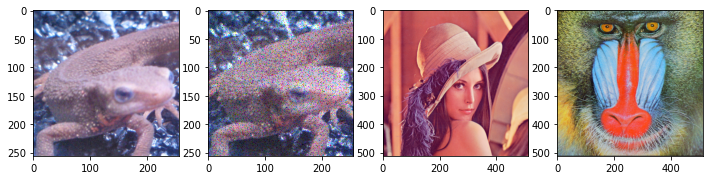

In [8]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256.png')
img_lena = io.imread('http://www.ess.ic.kanagawa-it.ac.jp/std_img/colorimage/lena_std.bmp')
img_noise = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_noise.png')
img_mandrill = io.imread('http://www.mis.med.akita-u.ac.jp/~kata/image/originalsource/mandrill.jpg')
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_dark.png')

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(img_orig)
plt.subplot(1,4,2)
plt.imshow(img_noise)
plt.subplot(1,4,3)
plt.imshow(img_lena)
plt.subplot(1,4,4)
plt.imshow(img_mandrill)
plt.show()

In [3]:
# func_list

def rgb2gray(img):
    _img = img.copy().astype(np.float32)
    img_gray = 0.2126*_img[...,0] + 0.7153*_img[...,1] + 0.0722*_img[...,2]
    img_gray = np.clip(img_gray,0,255)
    return img_gray.astype(np.uint8)

def binary(img_gray,th):
    _img = img_gray.copy().astype(np.float32)
    img_binary = np.minimum(_img//th, 1)
    img_binary = np.clip(img_binary,0,255)
    return img_binary.astype(np.uint8)

def rgb2binary(img,th):
    _img = img.copy().astype(np.float32)
    img_gray = rgb2gray(_img)
    img_binary = binary(img_gray,th)
    return img_binary

def otsu_thresh(img):
    _img = img.copy().astype(np.float32)

    max_vari = -1
    max_th = -1

    for th in range(1,254):
        m0 = _img[_img <= th].mean()
        m1 = _img[_img >  th].mean()
        w0 = _img[_img <= th].size
        w1 = _img[_img > th].size
        vari = w0 * w1 / ((w0 + w1) ** 2) * ((m0 - m1) ** 2) 
        if vari > max_vari:
            max_vari = vari
            max_th = th

    return rgb2binary(_img, max_th), max_th

def rgb2hsv(img_rgb):
    #rgb -> hsv
    _img = img_rgb.copy().astype(np.float32)

    v_max = _img.max(axis=2)
    v_min = _img.min(axis=2)
    v_argmin = _img.argmin(axis=2)

    img_hsv = np.zeros_like(_img, dtype=np.float32)

    r, g, b = np.split(_img, 3, axis=2)
    r, g, b = r[..., 0], g[..., 0], b[..., 0]

    diff = np.maximum(v_max - v_min, 1e-10)

    #Hue
    ind = v_argmin == 2
    img_hsv[..., 0][ind] = 60 * (g - r)[ind] / diff[ind] + 60
    ind = v_argmin == 0
    img_hsv[..., 0][ind] = 60 * (b - g)[ind] / diff[ind] + 180
    ind = v_argmin == 1
    img_hsv[..., 0][ind] = 60 * (r - b)[ind] / diff[ind] + 300
    ind = v_max == v_min
    img_hsv[..., 0][ind] = 0
    # Saturation
    img_hsv[..., 1] = v_max - v_min
    # Value
    img_hsv[..., 2] = v_max

    return img_hsv

def hsv2rgb(img_hsv):
    #hsv -> rgb
    _img_hsv = img_hsv.copy().astype(np.float32)

    h, s, v = np.split(_img_hsv, 3, axis=2)
    h, s, v = h[..., 0], s[..., 0], v[..., 0]
    _h = h / 60
    x = s * (1 - np.abs(_h % 2 - 1))
    z = np.zeros_like(x)
    vals = np.array([[s, x, z], [x, s, z], [z, s, x], [z, x, s], [x, z, s], [s, z, x]])
    
    img_rgb = np.zeros_like(_img_hsv)
    
    for i in range(6):
        ind = _h.astype(int) == i
        for j in range(3):
            img_rgb[..., j][ind] = (v - s)[ind] + vals[i, j][ind]
            
    return np.clip(img_rgb, 0, 255).astype(np.uint8)


def color_subtraction(img,div):
    _img = img.copy().astype(np.float32)

    th = 256 // div
    return np.clip(_img // th * th + th // 2, 0 ,255).astype(np.uint8)

def ave_pooling(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    outer_h = h % ksize
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left

    _img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    for iy in range(0, new_h, ksize):
        for ix in range(0, new_w, ksize):
          for ic in range(c):
            out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].mean()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out, 0, 255).astype(np.uint8)

def max_pooling(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    outer_h = h % ksize
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left

    _img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    for iy in range(0, new_h, ksize):
        for ix in range(0, new_w, ksize):
          for ic in range(c):
            out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].max()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out, 0, 255).astype(np.uint8)

def gaussian_filter(img, ksize, sigma):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    temp = np.zeros_like(_img)

    new_h, new_w = temp.shape[:2]
    c = 1 if len(temp.shape)==2 else temp.shape[2]

    k = np.zeros([ksize, ksize])
    for iy in range(ksize):
        for ix in range(ksize):
            k[ix, iy] = 1 / (2 * np.pi * (sigma**2)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

    k = k/k.sum()

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              temp[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = temp[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def median_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
                out[iy,ix,ic] = np.median(_img[iy:iy+ksize, ix:ix+ksize, ic])

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def smooth_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
                out[iy,ix,ic] = np.mean(_img[iy:iy+ksize, ix:ix+ksize, ic])

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def motion_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    k[range(ksize), range(ksize)] = 1/ksize


    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def maxmin_filter(img, ksize, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = _img[iy:iy+ksize, ix:ix+ksize, ic].max()-_img[iy:iy+ksize, ix:ix+ksize, ic].min()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def diff_filter(img, mode="y", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)


    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    
    k = np.array([[0,0,0],[-1,1,0],[0,0,0]])
    if mode == 'y':
        k = np.array([[0,-1,0],[0,1,0],[0,0,0]])

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def prewitt_filter(img, ksize, mode="x", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    if mode == 'x':
        k[:, 0] = 1
        k[:, -1] = -1
    else:
        k[0] = 1
        k[-1] = -1
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def sobel_filter(img, ksize, mode="x", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    if mode == 'x':
        k[:, 0] = 1
        k[ksize//2, 0] = 2
        k[:, -1] = -1
        k[ksize//2, -1] = -2
    else:
        k[0] = 1
        k[0, ksize//2] = 2
        k[-1] = -1
        k[-1, ksize//2] = -2
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def laplacian_filter(img, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def emboss_filter(img, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.array([[-2, -1, 0],[-1, 1, 1],[0, 1, 2]])
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def LoG_filter(img, k, sigma):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    for iy in range(ksize):
        for ix in range(ksize):
            k[ix, iy] = ((ix - ksize//2)**2 + (iy - ksize//2)**2 - 2*(sigma**2)) / (2 * np.pi * (sigma**6)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

    k = k/k.sum()

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def hist_normalize(img, a, b):
    _img = img.copy().astype(np.float32)

    c, d  = _img.min(), _img.max()
    out = (b-a)/(d-c)*(_img-c) + a
    out[_img<c] = a
    out[_img>d] = b

    return np.clip(out, 0, 255).astype(np.uint8)

def hist_scaleshift(img, mean, std):
    _img = img.copy().astype(np.float32)
    mean0, std0 = img.mean(), img.std()
    out = std / std0 * (img-mean0) + mean
    return np.clip(out, 0, 255).astype(np.uint8)

def hist_equalization(img):
    out = np.zeros_like(img, dtype=np.float32)

    s = img.size
    x_max = 255
    h = 0

    for i in range(256):
        h += (img == i).sum()
        out[img == i] = x_max / s * h

    return np.clip(out, 0, 255).astype(np.uint8)

def gamma_corr(img, c, g):
    out = ((1/c*(img/255))**(1/g))*255
    return np.clip(out, 0, 255).astype(np.uint8)

def nn_inter(img, a, b):
    out_h = int(img.shape[0]*a)
    out_w = int(img.shape[1]*b)
    out = np.zeros([out_h, out_w, img.shape[2]], dtype=np.uint8)

    xs, ys = np.meshgrid(range(out_h), range(out_w))
    out[ys, xs] = img[np.round(ys/a).astype(int), np.round(xs/b).astype(int)]
    return out  

def bilinear_inter(img, a, b):
    h,w,c = img.shape
    out_h = int(h*a)
    out_w = int(w*b)

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.floor(xs/b).astype(int)
    _ys = np.floor(ys/a).astype(int)

    dx = xs /b - _xs
    dy = ys /a - _ys

    dx = np.repeat(np.expand_dims(dx, axis=-1), c, axis=-1)
    dy = np.repeat(np.expand_dims(dy, axis=-1), c, axis=-1)

    _xs1p = np.minimum(_xs+1, w-1)
    _ys1p = np.minimum(_ys+1, h-1)

    out = (1-dx)*(1-dy)*img[_ys, _xs]+dx*(1-dy)*img[_ys,_xs1p]+(1-dx)*dy*img[_ys1p,_xs]+dx*dy*img[_ys1p,_xs1p]

    return np.clip(out, 0, 255).astype(np.uint8)

def bicubic_inter(img, a, b):
    h,w,c = img.shape
    out_h = int(h*a)
    out_w = int(w*b)
    out = np.zeros([out_h, out_w, c], dtype=np.float32)

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.floor(xs/b).astype(int)
    _ys = np.floor(ys/a).astype(int)

    dx1 = np.abs(xs / b - (_xs - 1))
    dx2 = np.abs(xs / b - _xs)
    dx3 = np.abs(xs / b - (_xs + 1))
    dx4 = np.abs(xs / b - (_xs + 2))
    dy1 = np.abs(ys / a - (_ys - 1))
    dy2 = np.abs(ys / a - _ys)
    dy3 = np.abs(ys / a - (_ys + 1))
    dy4 = np.abs(ys / a - (_ys + 2))

    dxs = [dx1, dx2, dx3, dx4]
    dys = [dy1, dy2, dy3, dy4]

    def weight(t, a=1):
        w = np.zeros_like(t)
        w[t<=1] =((a+2)*(t**3) - (a+3)*(t**2)+1)[t<=1]
        w[t>1] =(a*(t**3) - 5*a*(t**2)+8*a*t-4*a)[t>1]
        return w

    w_sum = np.zeros_like(out, dtype=np.float32)


    for j in range(-1,3):
        for i in range(-1,3):
            ind_x = np.minimum(np.maximum(_xs+i,0), w-1)
            ind_y = np.minimum(np.maximum(_ys+j,0), h-1)

            wx = weight(dxs[i+1])
            wy = weight(dys[j+1])  
            wx = np.repeat(np.expand_dims(wx, axis=-1),c, axis=-1)       
            wy = np.repeat(np.expand_dims(wy, axis=-1),c, axis=-1) 

            w_sum += wx*wy
            out += wx*wy*img[ind_y, ind_x]      
    
    return np.clip(out, 0, 255).astype(np.uint8)

def affine(img, affine_mat, out_shape):
    h,w,channel = img.shape

    [a,b,tx], [c,d,ty] = affine_mat
    out_h, out_w = out_shape

    out = np.zeros([out_h, out_w, channel])

    img_pad = np.pad(img, [(1,1),(1,1),(0,0)])

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.maximum(np.minimum((1/(a*d-b*c)*(d*xs-b*ys)-tx).astype(int) + 1, w + 1),0)
    _ys = np.maximum(np.minimum((1/(a*d-b*c)*(-c*xs+a*ys)-ty).astype(int) + 1, h + 1),0)

    out[ys, xs] = img_pad[_ys, _xs]
    return np.clip(out, 0, 255).astype(np.uint8)

#31 アフィン変換　スキュー

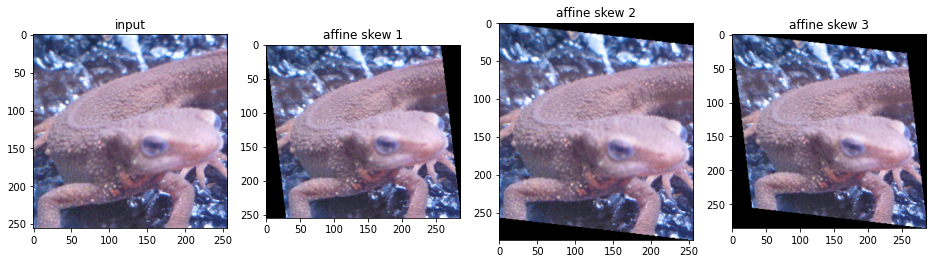

In [16]:
h, w, c = img_orig.shape
dx = 30
dy = 30


img_affine_skew_1 = affine(img_orig, [[1, dx/h, 0], [0, 1, 0]], (h,int(w+dx)))
img_affine_skew_2 = affine(img_orig, [[1, 0, 0], [dy/w, 1, 0]], (int(h+dy),w))
img_affine_skew_3 = affine(img_orig, [[1, dx/h, 0], [dy/w, 1, 0]], (int(h+dy),int(w+dx)))

plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1); plt.title('input'); plt.imshow(img_orig)
plt.subplot(1, 4, 2); plt.title('affine skew 1'); plt.imshow(img_affine_skew_1)
plt.subplot(1, 4, 3); plt.title('affine skew 2'); plt.imshow(img_affine_skew_2)
plt.subplot(1, 4, 4); plt.title('affine skew 3'); plt.imshow(img_affine_skew_3)
plt.show()

#32 フーリエ変換

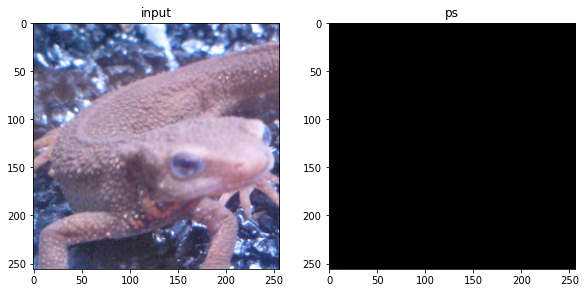

In [29]:
channel = 3

img = img_orig.copy()

H, W, _ = img.shape
K, L =256, 256

G = np.zeros((L, K, channel), dtype=np.complex)

xs, ys = np.meshgrid(range(W), range(H))

for c in range(channel):
    for l in range(L):
        for k in range(K):
            G[l,k,c] = np.sum(img[..., c] * np.exp(-2j * np.pi*(xs*k/W+ys*l/H)))/np.sqrt(W*H)

ps = (np.abs(G)/np.abs(G).max()*255).astype(np.uint8)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img_orig)
plt.subplot(1, 3, 2); plt.title('ps'); plt.imshow(ps, cmap='gray')
plt.show()

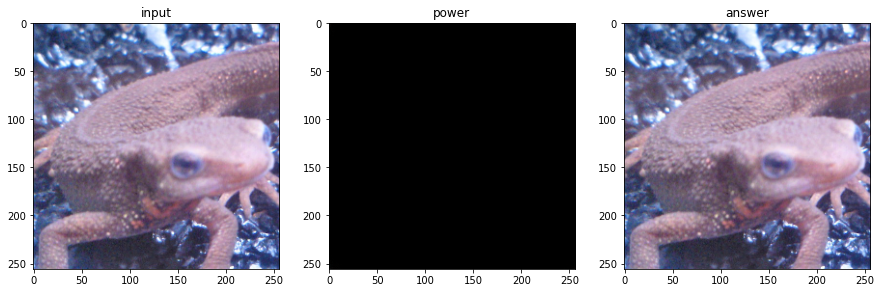

In [30]:
H = 256
W = 256

out = np.zeros((H, W, channel), dtype=np.float32)

xs, ys = np.meshgrid(range(W), range(H))

for c in range(channel):
    for l in range(H):
        for k in range(K):
            out[l,k,c] = np.abs(np.sum(G[..., c] * np.exp(2j * np.pi*(xs*k/W+ys*l/H)))/np.sqrt(K*L))

out = np.clip(out, 0, 255).astype(np.uint8)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img_orig)
plt.subplot(1, 3, 2); plt.title('power'); plt.imshow(ps, cmap='gray')
plt.subplot(1, 3, 3); plt.title('answer'); plt.imshow(out, cmap='gray')
plt.show()